## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import tensorflow as tf
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 40 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.2]
redice_lr_patient = [3, 5]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 3s 61us/step - loss: 2.9100 - accuracy: 0.1141 - val_loss: 2.3068 - val_accuracy: 0.1326
Epoch 2/40
50000/50000 [==============================] - 3s 54us/step - loss: 2.6699 - accuracy: 0.1504 - val_loss: 2.2469 - val_accuracy: 0.1698
Epoch 3/40
50000/50000 [==============================] - 2s 48us/step - loss: 2.5193 - accuracy: 0.1845 - val_loss: 2.2072 - val_accuracy: 0.1948
Epoch 4/40
50000/50000 [==============================] - 3s 54us/step - loss: 2.4216 - accuracy: 0.2065 - val_loss: 2.1786 - val_accuracy: 0.2066
Epoch 5/40
50000/50000 [==============================] - 3s 64us/step - loss: 2.3505 - accuracy: 0.2245 - val_loss: 2.1552 - val_accuracy: 0.2226
Epoch 6/40
50000/50000 [==============================] - 3s 65us/step - loss: 2.2932 - accuracy: 0.2402 - val_loss: 2.1368 - val_accuracy: 0.2357
Epoch 7/40
50000/50000 [==============================] - 2s 48us/st

Epoch 6/40
50000/50000 [==============================] - 3s 56us/step - loss: 2.3129 - accuracy: 0.2358 - val_loss: 2.1385 - val_accuracy: 0.2417
Epoch 7/40
50000/50000 [==============================] - 3s 59us/step - loss: 2.2685 - accuracy: 0.2458 - val_loss: 2.1218 - val_accuracy: 0.2593
Epoch 8/40
50000/50000 [==============================] - 3s 59us/step - loss: 2.2324 - accuracy: 0.2565 - val_loss: 2.1120 - val_accuracy: 0.2687
Epoch 9/40
50000/50000 [==============================] - 3s 57us/step - loss: 2.1998 - accuracy: 0.2632 - val_loss: 2.1056 - val_accuracy: 0.2760
Epoch 10/40
50000/50000 [==============================] - 3s 58us/step - loss: 2.1722 - accuracy: 0.2706 - val_loss: 2.1014 - val_accuracy: 0.2827
Epoch 11/40
50000/50000 [==============================] - 3s 60us/step - loss: 2.1471 - accuracy: 0.2773 - val_loss: 2.0975 - val_accuracy: 0.2856
Epoch 12/40
50000/50000 [==============================] - 3s 61us/step - loss: 2.1249 - accuracy: 0.2833 - val_loss

50000/50000 [==============================] - 5s 101us/step - loss: 2.1550 - accuracy: 0.2842 - val_loss: 2.1034 - val_accuracy: 0.2877
Epoch 12/40
50000/50000 [==============================] - 5s 96us/step - loss: 2.1312 - accuracy: 0.2897 - val_loss: 2.0954 - val_accuracy: 0.2946
Epoch 13/40
50000/50000 [==============================] - 6s 119us/step - loss: 2.1095 - accuracy: 0.2950 - val_loss: 2.0860 - val_accuracy: 0.2992
Epoch 14/40
50000/50000 [==============================] - 5s 109us/step - loss: 2.0888 - accuracy: 0.2988 - val_loss: 2.0773 - val_accuracy: 0.3028
Epoch 15/40
50000/50000 [==============================] - 4s 89us/step - loss: 2.0704 - accuracy: 0.3047 - val_loss: 2.0672 - val_accuracy: 0.3081
Epoch 16/40
50000/50000 [==============================] - 5s 94us/step - loss: 2.0516 - accuracy: 0.3089 - val_loss: 2.0573 - val_accuracy: 0.3106
Epoch 17/40
50000/50000 [==============================] - 5s 108us/step - loss: 2.0361 - accuracy: 0.3134 - val_loss: 2.

50000/50000 [==============================] - 4s 71us/step - loss: 0.7848 - accuracy: 0.7366 - val_loss: 1.4364 - val_accuracy: 0.5064
Epoch 16/40
50000/50000 [==============================] - 4s 74us/step - loss: 0.7572 - accuracy: 0.7461 - val_loss: 1.4994 - val_accuracy: 0.4983

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 17/40
50000/50000 [==============================] - 4s 80us/step - loss: 0.7034 - accuracy: 0.7701 - val_loss: 1.3933 - val_accuracy: 0.5294
Epoch 18/40
50000/50000 [==============================] - 4s 84us/step - loss: 0.6789 - accuracy: 0.7808 - val_loss: 1.4093 - val_accuracy: 0.5271
Epoch 19/40
50000/50000 [==============================] - 4s 88us/step - loss: 0.6620 - accuracy: 0.7888 - val_loss: 1.4347 - val_accuracy: 0.5156

Epoch 00019: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 20/40
50000/50000 [==============================] - 4s 83us/step - loss: 0.6295 - accuracy: 0.8043 - val

50000/50000 [==============================] - 4s 89us/step - loss: 2.1793 - accuracy: 0.2692 - val_loss: 2.1896 - val_accuracy: 0.2623
Epoch 16/40
50000/50000 [==============================] - 3s 67us/step - loss: 2.1655 - accuracy: 0.2732 - val_loss: 2.1835 - val_accuracy: 0.2650
Epoch 17/40
50000/50000 [==============================] - 3s 66us/step - loss: 2.1523 - accuracy: 0.2762 - val_loss: 2.1765 - val_accuracy: 0.2664
Epoch 18/40
50000/50000 [==============================] - 3s 65us/step - loss: 2.1396 - accuracy: 0.2796 - val_loss: 2.1682 - val_accuracy: 0.2700
Epoch 19/40
50000/50000 [==============================] - 3s 64us/step - loss: 2.1282 - accuracy: 0.2837 - val_loss: 2.1595 - val_accuracy: 0.2718
Epoch 20/40
50000/50000 [==============================] - 3s 62us/step - loss: 2.1170 - accuracy: 0.2869 - val_loss: 2.1510 - val_accuracy: 0.2747
Epoch 21/40
50000/50000 [==============================] - 3s 64us/step - loss: 2.1062 - accuracy: 0.2902 - val_loss: 2.1418

Epoch 20/40
50000/50000 [==============================] - 3s 68us/step - loss: 2.0825 - accuracy: 0.2907 - val_loss: 2.1112 - val_accuracy: 0.2840
Epoch 21/40
50000/50000 [==============================] - 3s 64us/step - loss: 2.0714 - accuracy: 0.2940 - val_loss: 2.1034 - val_accuracy: 0.2849
Epoch 22/40
50000/50000 [==============================] - 3s 66us/step - loss: 2.0626 - accuracy: 0.2969 - val_loss: 2.0952 - val_accuracy: 0.2849
Epoch 23/40
50000/50000 [==============================] - 3s 66us/step - loss: 2.0524 - accuracy: 0.2989 - val_loss: 2.0879 - val_accuracy: 0.2886
Epoch 24/40
50000/50000 [==============================] - 3s 60us/step - loss: 2.0441 - accuracy: 0.3021 - val_loss: 2.0806 - val_accuracy: 0.2883
Epoch 25/40
50000/50000 [==============================] - 3s 65us/step - loss: 2.0364 - accuracy: 0.3047 - val_loss: 2.0736 - val_accuracy: 0.2895
Epoch 26/40
50000/50000 [==============================] - 3s 59us/step - loss: 2.0285 - accuracy: 0.3065 - val_

Epoch 24/40
50000/50000 [==============================] - 3s 63us/step - loss: 2.1293 - accuracy: 0.2833 - val_loss: 2.1536 - val_accuracy: 0.2833

Epoch 00024: ReduceLROnPlateau reducing learning rate to 3.9062502565911926e-09.
Epoch 25/40
50000/50000 [==============================] - 3s 61us/step - loss: 2.1290 - accuracy: 0.2831 - val_loss: 2.1535 - val_accuracy: 0.2832
Epoch 26/40
50000/50000 [==============================] - 3s 65us/step - loss: 2.1282 - accuracy: 0.2826 - val_loss: 2.1536 - val_accuracy: 0.2835
Epoch 27/40
50000/50000 [==============================] - 3s 60us/step - loss: 2.1294 - accuracy: 0.2835 - val_loss: 2.1534 - val_accuracy: 0.2834
Epoch 28/40
50000/50000 [==============================] - 3s 59us/step - loss: 2.1308 - accuracy: 0.2815 - val_loss: 2.1533 - val_accuracy: 0.2832
Epoch 29/40
50000/50000 [==============================] - 3s 60us/step - loss: 2.1291 - accuracy: 0.2825 - val_loss: 2.1534 - val_accuracy: 0.2831

Epoch 00029: ReduceLROnPlatea

50000/50000 [==============================] - 3s 69us/step - loss: 0.5468 - accuracy: 0.8289 - val_loss: 1.5373 - val_accuracy: 0.5148

Epoch 00025: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 26/40
50000/50000 [==============================] - 4s 72us/step - loss: 0.5226 - accuracy: 0.8395 - val_loss: 1.4664 - val_accuracy: 0.5309
Epoch 27/40
50000/50000 [==============================] - 4s 76us/step - loss: 0.5150 - accuracy: 0.8437 - val_loss: 1.4766 - val_accuracy: 0.5303
Epoch 28/40
50000/50000 [==============================] - 4s 82us/step - loss: 0.5075 - accuracy: 0.8467 - val_loss: 1.4831 - val_accuracy: 0.5330

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 29/40
50000/50000 [==============================] - 4s 83us/step - loss: 0.4950 - accuracy: 0.8534 - val_loss: 1.4829 - val_accuracy: 0.5315
Epoch 30/40
50000/50000 [==============================] - 4s 79us/step - loss: 0.4916 - accuracy: 0.8537 - val

Epoch 27/40
50000/50000 [==============================] - 3s 59us/step - loss: 1.8009 - accuracy: 0.3799 - val_loss: 1.8588 - val_accuracy: 0.3595
Epoch 28/40
50000/50000 [==============================] - 3s 60us/step - loss: 1.7911 - accuracy: 0.3828 - val_loss: 1.8513 - val_accuracy: 0.3633
Epoch 29/40
50000/50000 [==============================] - 3s 66us/step - loss: 1.7800 - accuracy: 0.3852 - val_loss: 1.8425 - val_accuracy: 0.3670
Epoch 30/40
50000/50000 [==============================] - 3s 63us/step - loss: 1.7708 - accuracy: 0.3880 - val_loss: 1.8344 - val_accuracy: 0.3700
Epoch 31/40
50000/50000 [==============================] - 3s 67us/step - loss: 1.7617 - accuracy: 0.3916 - val_loss: 1.8266 - val_accuracy: 0.3727
Epoch 32/40
50000/50000 [==============================] - 3s 64us/step - loss: 1.7524 - accuracy: 0.3953 - val_loss: 1.8199 - val_accuracy: 0.3752
Epoch 33/40
50000/50000 [==============================] - 4s 72us/step - loss: 1.7441 - accuracy: 0.3964 - val_

Epoch 32/40
50000/50000 [==============================] - 4s 83us/step - loss: 1.7307 - accuracy: 0.4034 - val_loss: 1.7959 - val_accuracy: 0.3865
Epoch 33/40
50000/50000 [==============================] - 6s 126us/step - loss: 1.7233 - accuracy: 0.4053 - val_loss: 1.7900 - val_accuracy: 0.3872
Epoch 34/40
50000/50000 [==============================] - 10s 190us/step - loss: 1.7160 - accuracy: 0.4081 - val_loss: 1.7846 - val_accuracy: 0.3893
Epoch 35/40
50000/50000 [==============================] - 8s 164us/step - loss: 1.7076 - accuracy: 0.4108 - val_loss: 1.7784 - val_accuracy: 0.3923
Epoch 36/40
50000/50000 [==============================] - 10s 191us/step - loss: 1.7012 - accuracy: 0.4137 - val_loss: 1.7737 - val_accuracy: 0.3932
Epoch 37/40
50000/50000 [==============================] - 8s 164us/step - loss: 1.6940 - accuracy: 0.4150 - val_loss: 1.7683 - val_accuracy: 0.3946
Epoch 38/40
50000/50000 [==============================] - 6s 112us/step - loss: 1.6870 - accuracy: 0.418

Epoch 37/40
50000/50000 [==============================] - 3s 58us/step - loss: 1.7240 - accuracy: 0.4002 - val_loss: 1.8177 - val_accuracy: 0.3744
Epoch 38/40
50000/50000 [==============================] - 3s 58us/step - loss: 1.7166 - accuracy: 0.4035 - val_loss: 1.8121 - val_accuracy: 0.3772
Epoch 39/40
50000/50000 [==============================] - 3s 61us/step - loss: 1.7096 - accuracy: 0.4054 - val_loss: 1.8071 - val_accuracy: 0.3794
Epoch 40/40
50000/50000 [==============================] - 3s 61us/step - loss: 1.7030 - accuracy: 0.4074 - val_loss: 1.8023 - val_accuracy: 0.3811


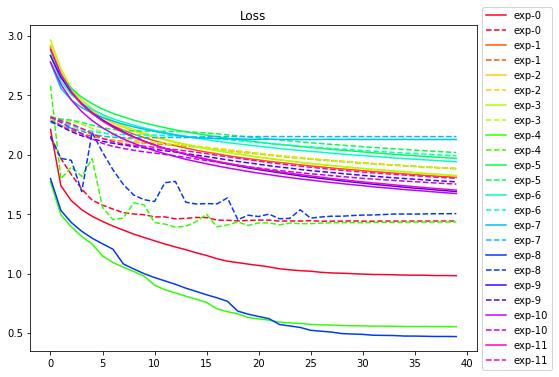

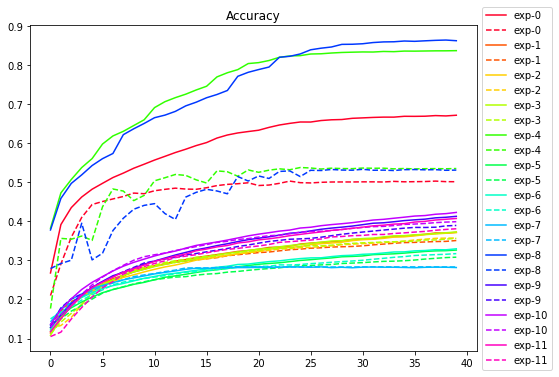

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()